# Single source sand piles

An exploration of the single source sand pile model and the fractals it produces.

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

## Sand pile

`Sand.py` contains an implementation of the sand pile model.

In [2]:
from Sand import SandPile, SandPileViewer

`run_ss_pile` initializes a pile with `2**k` grains in the center cell, then runs until equilibrium.

In [3]:
def run_ss_pile(n, k=10):
    """Runs a single source model.
    
    k: integer power of two of height
    """
    pile = SandPile(n)
    pile.single_source(2**k)
    print(pile.run())        
    viewer = SandPileViewer(pile)
    return pile, viewer

After initialization, the result looks like a fractal, but as far as I know, no one has estimated its fractal dimension.

(14244, 4900462)
CPU times: user 9.43 s, sys: 4 ms, total: 9.44 s
Wall time: 9.43 s


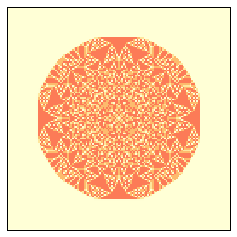

In [4]:
% time pile, viewer = run_ss_pile(n=131, k=14)
viewer.draw()

`draw_four` draws the cells with each of the given values.

In [5]:
def draw_four(pile, vals=range(4)):
    thinkplot.preplot(rows=2, cols=2)
    
    for i, val in enumerate(vals):
        thinkplot.subplot(i+1)
        viewer.draw_array(pile.array==vals[i], vmax=1)

I'll estimate the fractal dimension for each of these patterns separately.

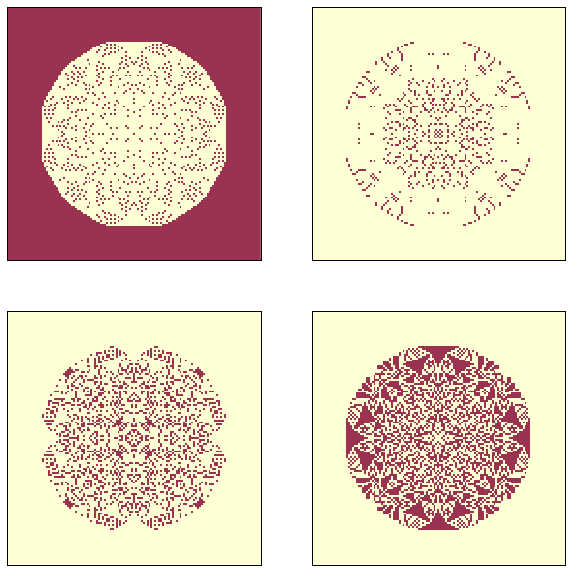

In [6]:
draw_four(pile)

## Bigger sand piles

Wesley Pegden at CMU has studied the single source sand pile model and the fractals it produces.  On [this web page](http://math.cmu.edu/~wes/sandgallery.html) you can explore results he generated from sand piles with a large number of grains in the initial tower.  I'll use the images he produced to estimate the dimension of these fractals.

`read_pile` reads the images Prof Pegden generated and makes a `SandPile` object.

In [7]:
from scipy.ndimage import imread

def read_pile(k):
    """Reads an image of a single souce sand pile model.
    
    Images generated by Wesley Pegden,
    available from http://math.cmu.edu/~wes/piles/
    """
    filename = 's%dmono.png' % k
    array = imread(filename, mode='L')
    n, m = array.shape
    
    # select the lower-right quadrant
    array = array[n//2:, m//2:]
    
    # set the top row to an invalid value
    # to avoid double-counting
    array[0, 1:] = 17
    
    pile = SandPile(1)
    pile.array = array
    return pile

Here's an example with `2**20` grains.

In [8]:
k_pile = read_pile(20)
k_pile.array.shape

(410, 410)

Here's what the four patterns look like.

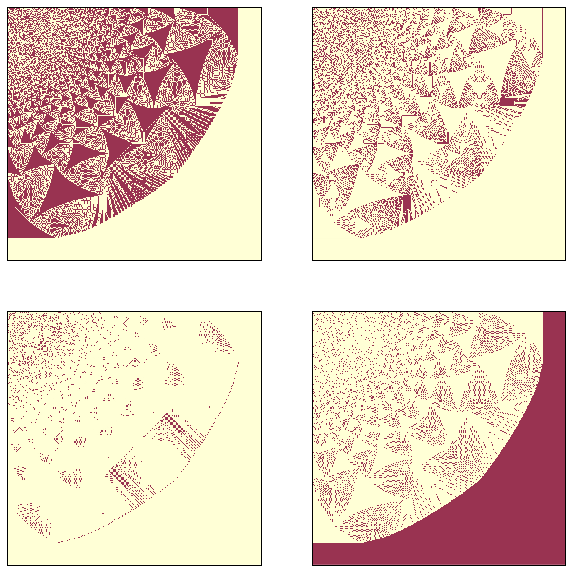

In [9]:
viewer = SandPileViewer(k_pile)

vals = [0, 85, 170, 255]
draw_four(k_pile, vals)

## Estimating dimensions

`radial_box_count` applies a radial version of the box counting algorithm.

In [10]:
from scipy.stats import linregress

def radial_box_count(pile, val, plot=False):
    """Estimates the fractal dimension of an array.
    
    pile: SandPile
    val: value to count
    plot: boolean, whether to plot cumulative sum vs distance
    
    returns: estimated dimension
    """
    a = pile.array==val
    n, m = a.shape
    
    # for each non-zero cell, compute the disance from the origin
    indices = np.array(np.nonzero(a))
    distances = np.sum(indices**2, axis=0)**0.5
    
    # for each distance, x, compute the number of cells with distance
    # not greater than x
    xs, counts = np.unique(distances, return_counts=True)
    ys = np.cumsum(counts)

    # select only the range where the cell count is greater than zero
    # and we're still inside the perimeter circle
    r = min(n, m) - 1.1
    legit = np.where((xs>0) & (xs<r))
    xs = xs[legit]
    ys = ys[legit]

    # compute the area of a circle with radius x, for comparison
    d2 = [np.pi*x**2 for x in xs]
    
    if plot:
        thinkplot.plot(xs, d2, label='d=2')
        thinkplot.plot(xs, ys, label='sand pile')
        thinkplot.config(xlabel='distance', xscale='log',
                         ylabel='number of cells', yscale='log',
                         loc='upper left')
    
    # fit a curve to the line and return the slope
    params = linregress(np.log(xs), np.log(ys))
    return params[0]

The following plots show cell counts versus distance for each of the 4 values, along with the estimated fractal dimensions.

2.169

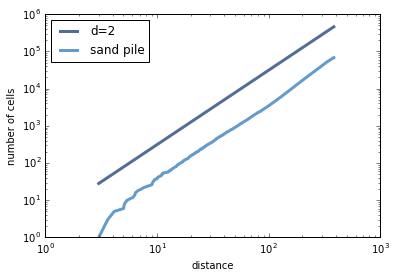

In [11]:
radial_box_count(k_pile, 0, plot=True)

1.828

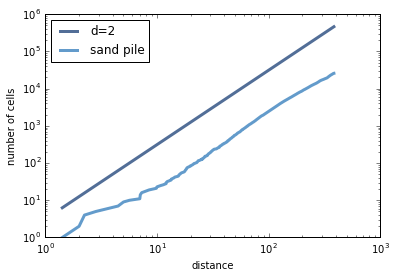

In [12]:
radial_box_count(k_pile, 85, plot=True)

1.355

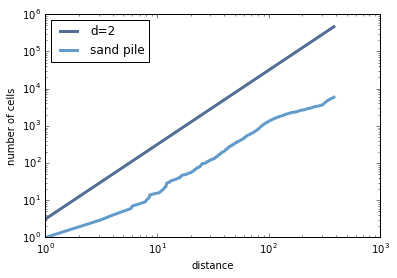

In [13]:
radial_box_count(k_pile, 170, plot=True)

2.519

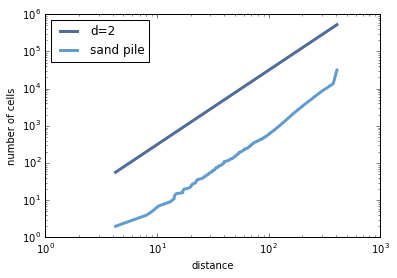

In [14]:
radial_box_count(k_pile, 255, plot=True)

`estimate_four_radial` calls `radial_box_count` for each value.

In [15]:
def estimate_four_radial(pile, vals=range(4)):
    dims = [radial_box_count(pile, val) for val in vals]
    return dims

And here are the four dimensions.

In [16]:
estimate_four_radial(k_pile, vals)

[2.169, 1.828, 1.355, 2.519]

It sure looks like they are fractals, although the dimensions greater than 2 are surprising.

Let's see what happens as we increase the size of the pile.

`process_pile` takes a value of `k`, reads the results of the sand pile with `2**k` grains, and estimates the dimensions.

In [17]:
def process_pile(k):
    """Read an image and estimates dimensions.
    
    k: reads results starting with 2^k grains
    
    returns: list of 4 dimensions
    """
    pile = read_pile(k)
    vals = [0, 85, 170, 255]
    dims = estimate_four_radial(pile, vals)
    return np.array(dims)

And here are the results for a range of values of `k`.

In [18]:
np.set_printoptions(precision=4)

ks = range(10, 26)
for k in ks:
    dims = process_pile(k)
    print(k, dims)

10 [ 1.7308  1.563   2.6762  0.7751]
11 [ 1.8127  1.8163  2.2902  1.3133]
12 [ 1.9158  1.9331  1.763   1.4415]
13 [ 2.0721  1.7016  1.7659  2.3933]
14 [ 2.1234  1.8487  1.4476  2.5505]
15 [ 2.1317  1.7756  1.6045  2.5421]
16 [ 2.0606  1.8966  1.6208  2.4119]
17 [ 2.1201  1.8799  1.5338  2.4595]
18 [ 2.1748  1.855   1.4378  2.6163]
19 [ 2.1587  1.8538  1.4463  2.4759]
20 [ 2.1693  1.8277  1.3545  2.5192]
21 [ 2.1785  1.7928  1.3467  2.5405]
22 [ 2.1931  1.7649  1.3339  2.5081]
23 [ 2.1833  1.7624  1.3153  2.4947]
24 [ 2.1733  1.7665  1.306   2.4709]
25 [ 2.1642  1.7615  1.3142  2.4436]


Above `k=14` the estimates are pretty stable.

In [19]:
res = [process_pile(k) for k in range(10, 26)]

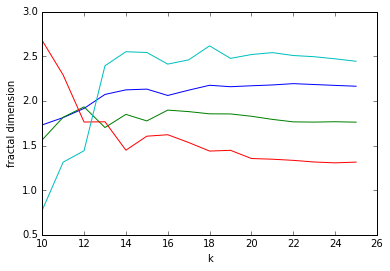

In [20]:
lines = np.array(res)
plt.plot(ks, lines)
plt.xlabel('k')
plt.ylabel('fractal dimension');

Might be interesting to try a few more to see if those trends are going anywhere.